In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Big Data/Datasets/gold.us.txt")
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3201 non-null   object 
 1   Open     3201 non-null   float64
 2   High     3201 non-null   float64
 3   Low      3201 non-null   float64
 4   Close    3201 non-null   float64
 5   Volume   3201 non-null   int64  
 6   OpenInt  3201 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 175.2+ KB


In [25]:
df['Date'] = pd.to_datetime(df['Date']) # Mengkonversi tipe data pada kolom 'Date' menjadi Datetime.
df.set_index('Date', inplace=True) # Mengubah kolom 'Date' menjadi yang terbaru
df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,13.082,13.243,12.814,13.034,317634,0
2005-02-28,12.938,13.226,12.863,13.072,244590,0
2005-03-01,12.794,12.977,12.290,12.528,792341,0
2005-03-02,12.863,12.938,12.586,12.776,378491,0
2005-03-03,12.566,12.719,12.480,12.499,171554,0


In [26]:
# Mengambil data bulanan menggunakan resampling
df_monthly = df['Close'].resample('M').last()  # Mengambil harga tutup bulanan
df_monthly

/tmp/ipython-input-2399080249.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df['Close'].resample('M').last()  # Mengambil harga tutup bulanan


,Close
Date,
2005-02-28,13.072
2005-03-31,11.802
2005-04-30,11.345
2005-05-31,11.926
2005-06-30,13.426
...,...
2017-07-31,92.940
2017-08-31,102.490
2017-09-30,97.660


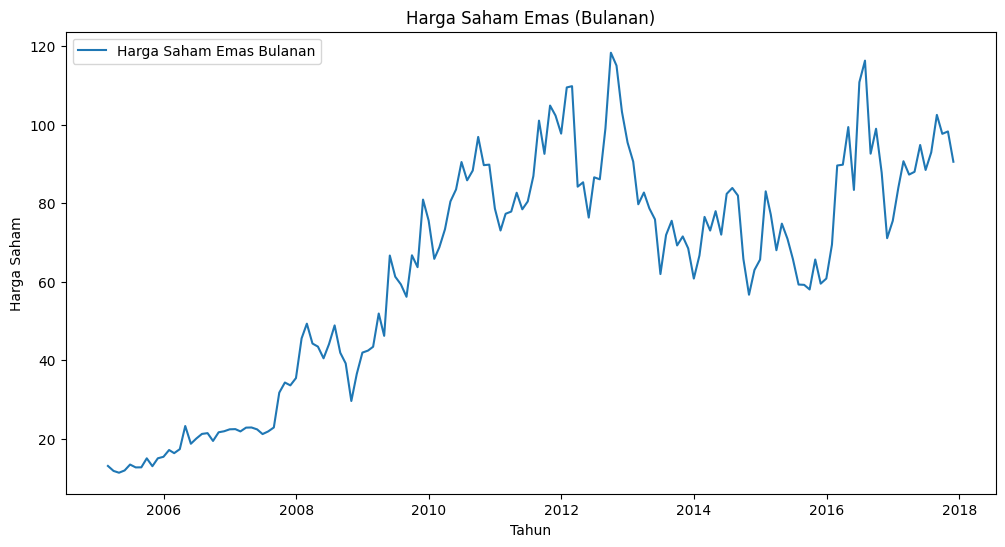

In [27]:
# Visualisasi data bulanan
plt.figure(figsize=(12,6))
plt.plot(df_monthly, label='Harga Saham Emas Bulanan')
plt.title('Harga Saham Emas (Bulanan)')
plt.xlabel('Tahun')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()

In [28]:
# Membuat fitur (X) dan target (Y)
df_monthly = df_monthly.reset_index()
df_monthly['Month'] = df_monthly['Date'].dt.month  # Ekstrak bulan
df_monthly['Prev Close'] = df_monthly['Close'].shift(1)  # Harga saham bulan sebelumnya
df_monthly = df_monthly.dropna()  # Menghapus NaN yang terbentuk

# Menentukan fitur dan target
X = df_monthly[['Prev Close']]      # Fitur: harga bulan sebelumnya
Y = df_monthly['Close']             # Target: harga bulan ini

# Membagi data menjadi train dan test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# --- Support Vector Regression (Linear Kernel) ---
model = SVR(kernel='linear', C=1.0, epsilon=0.1)
model.fit(X_train, Y_train)

# Prediksi di data test
predictions = model.predict(X_test)

# Evaluasi model
mse = mean_squared_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 91.15788469451643
R-squared: 0.8987890531116189


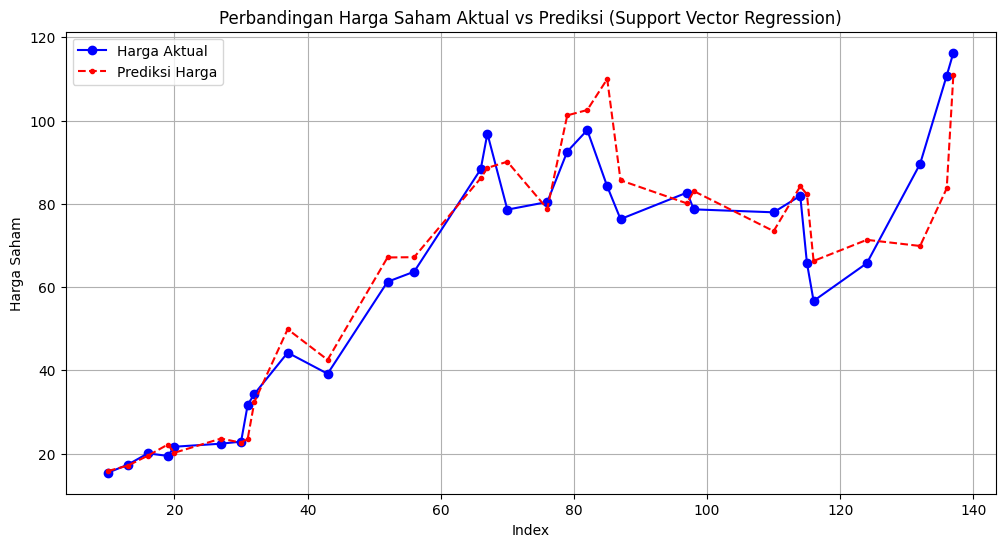

In [36]:
# Buat dataframe untuk visualisasi
results = X_test.copy()
results['Actual'] = Y_test
results['Predicted'] = predictions

# Urutkan berdasarkan index agar garis terlihat jelas
results = results.sort_index()

# Plot
plt.figure(figsize=(12,6))
plt.plot(results.index, results['Actual'], color='blue', marker='o', linestyle='-', label='Harga Aktual')
plt.plot(results.index, results['Predicted'], color='red', marker='.', linestyle='--', label='Prediksi Harga')
plt.title('Perbandingan Harga Saham Aktual vs Prediksi (Support Vector Regression)')
plt.xlabel('Index')
plt.ylabel('Harga Saham')
plt.legend()
plt.grid(True)
plt.show()

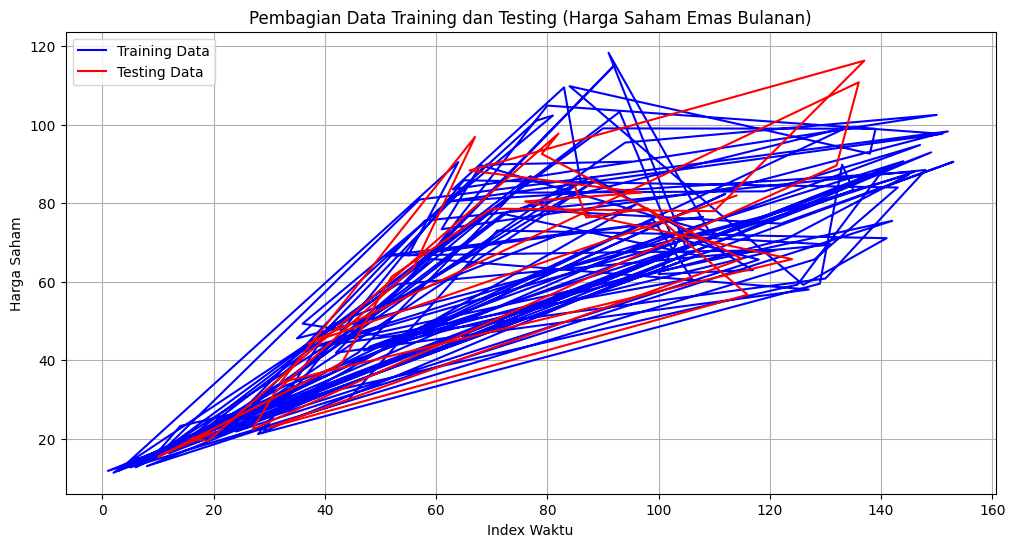

In [30]:
plt.figure(figsize=(12,6))

# Plot Training
plt.plot(Y_train.index, Y_train.values,
         label='Training Data', color='blue')

# Plot Testing
plt.plot(Y_test.index, Y_test.values,
         label='Testing Data', color='red')

plt.title('Pembagian Data Training dan Testing (Harga Saham Emas Bulanan)')
plt.xlabel('Index Waktu')
plt.ylabel('Harga Saham')
plt.legend()
plt.grid(True)
plt.show()

<class 'pandas.core.series.Series'>
Index: 31 entries, 85 to 114
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


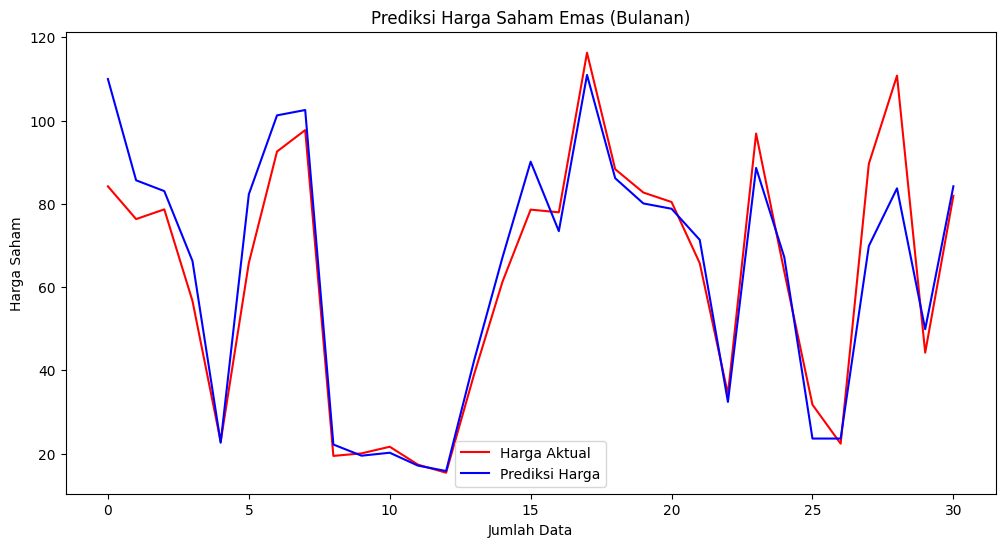

In [31]:
# Visualisasi hasil prediksi dan data aktual
Y_test.info()
plt.figure(figsize=(12, 6))
plt.plot(Y_test.values, label='Harga Aktual', color='red')
plt.plot(predictions, label='Prediksi Harga', color='blue')
plt.title('Prediksi Harga Saham Emas (Bulanan)')
plt.xlabel('Jumlah Data')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()

In [32]:
# Prediksi 5 bulan ke depan berdasarkan model yang telah dilatih
# Menggunakan harga bulan terakhir (bulan terakhir dalam data pelatihan) untuk prediksi
last_month_close = df_monthly['Close'].iloc[-1]
predictions_5_months = []

# Lakukan prediksi untuk 5 bulan ke depan
for _ in range(5):  # Mengubah 6 menjadi 5 untuk prediksi 5 bulan
    next_month_pred = model.predict(np.array([[last_month_close]]))
    predictions_5_months.append(next_month_pred[0])
    last_month_close = next_month_pred[0]  # Update harga untuk bulan berikutnya

# Menampilkan prediksi 5 bulan ke depan
predicted_months = [df_monthly['Date'].iloc[-1] + pd.DateOffset(months=i) for i in range(1, 6)]  # Ubah 6 menjadi 5
predictions_5_months_df = pd.DataFrame({'Month': predicted_months, 'Predicted Close': predictions_5_months})

print("Prediksi Harga Saham Emas untuk 5 Bulan Kedepan:")
print(predictions_5_months_df)

Prediksi Harga Saham Emas untuk 5 Bulan Kedepan:
       Month  Predicted Close
0 2017-12-30        90.850649
1 2018-01-30        91.149342
2 2018-02-28        91.446091
3 2018-03-30        91.740910
4 2018-04-30        92.033811


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


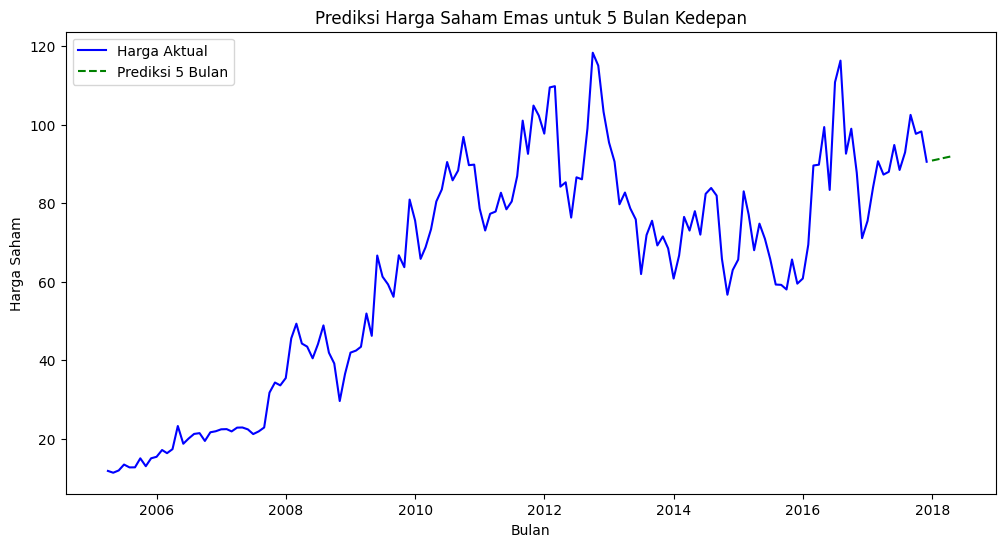

In [33]:
# Visualisasi prediksi 5 bulan ke depan
plt.figure(figsize=(12,6))
plt.plot(df_monthly['Date'], df_monthly['Close'], label='Harga Aktual', color='blue')
plt.plot(predictions_5_months_df['Month'], predictions_5_months_df['Predicted Close'], label='Prediksi 5 Bulan', color='green', linestyle='--')
plt.title('Prediksi Harga Saham Emas untuk 5 Bulan Kedepan')
plt.xlabel('Bulan')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()

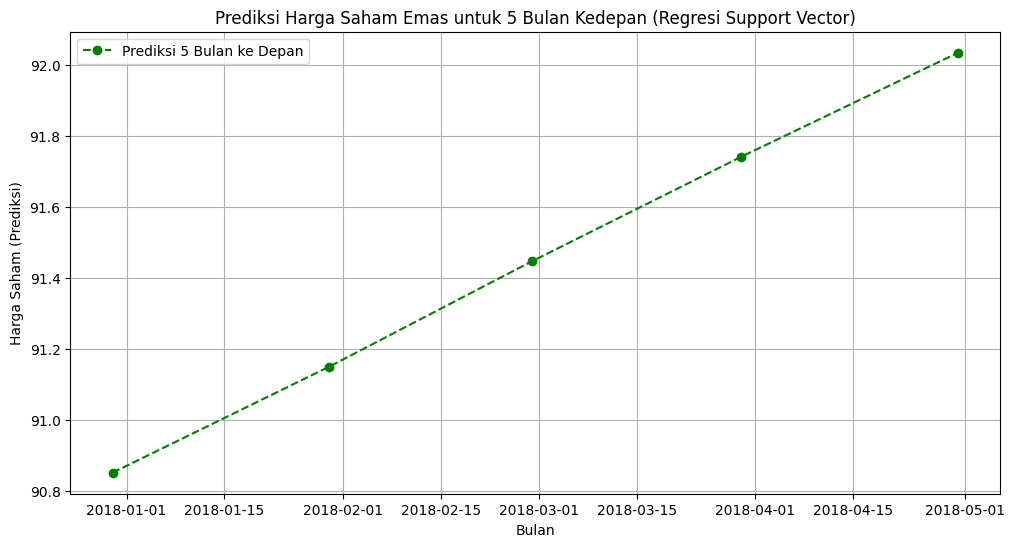

In [35]:
# Visualisasi hanya prediksi 5 bulan ke depan
plt.figure(figsize=(12,6))
plt.plot(predictions_5_months_df['Month'], predictions_5_months_df['Predicted Close'],
         label='Prediksi 5 Bulan ke Depan', color='green', marker='o', linestyle='--')
plt.title('Prediksi Harga Saham Emas untuk 5 Bulan Kedepan (Regresi Support Vector)')
plt.xlabel('Bulan')
plt.ylabel('Harga Saham (Prediksi)')
plt.grid(True)
plt.legend()
plt.show()